In [1]:
# Standard Libraries
import os
import random
import itertools
import warnings

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# PyTorch for Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

# TensorFlow and Keras
import tensorflow as tf

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Image Processing
from PIL import Image
import cv2

# Ignore Warnings
warnings.filterwarnings("ignore")


In [2]:
# lets us now Visualise the Class Distribution

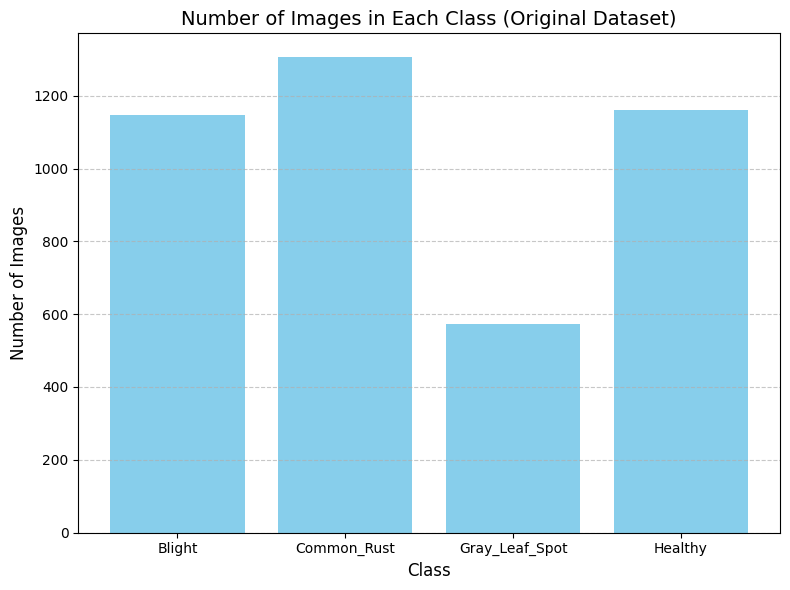

In [3]:
data_path = "dataset" 
# Load the dataset
original_dataset = datasets.ImageFolder(root=data_path)

# Get class names and counts
class_names = original_dataset.classes
class_counts = pd.Series(original_dataset.targets).value_counts().sort_index()

# Plot a bar graph for the number of images in each class
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Images in Each Class (Original Dataset)', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:

# Splitting the Data Into Train, Validation and Test Sets¶

# Because the data is not seperated, it should be splitted into Train, Validation and Test sets. 
# To do that, I used splitfolders library and splitted the data into Train, Validation and Test sets 
# by 70%, 20% and 10% respectively.
import splitfolders

In [9]:
splitfolders.ratio("dataset",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 4188 files [00:02, 2064.06 files/s]


In [10]:
# Resizing and Normalizing methods are applied to all of the datasets but data augmentation 
# techniques are only applied to Train set in order to richen the data so that the model possibly 
# will yield more accurate results.

In [13]:
# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10
LEARNING_RATE = 0.001


# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
# Dataset Loading and Preprocessing

In [15]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [16]:

# Load Dataset
data_dir = "splitted_data/"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



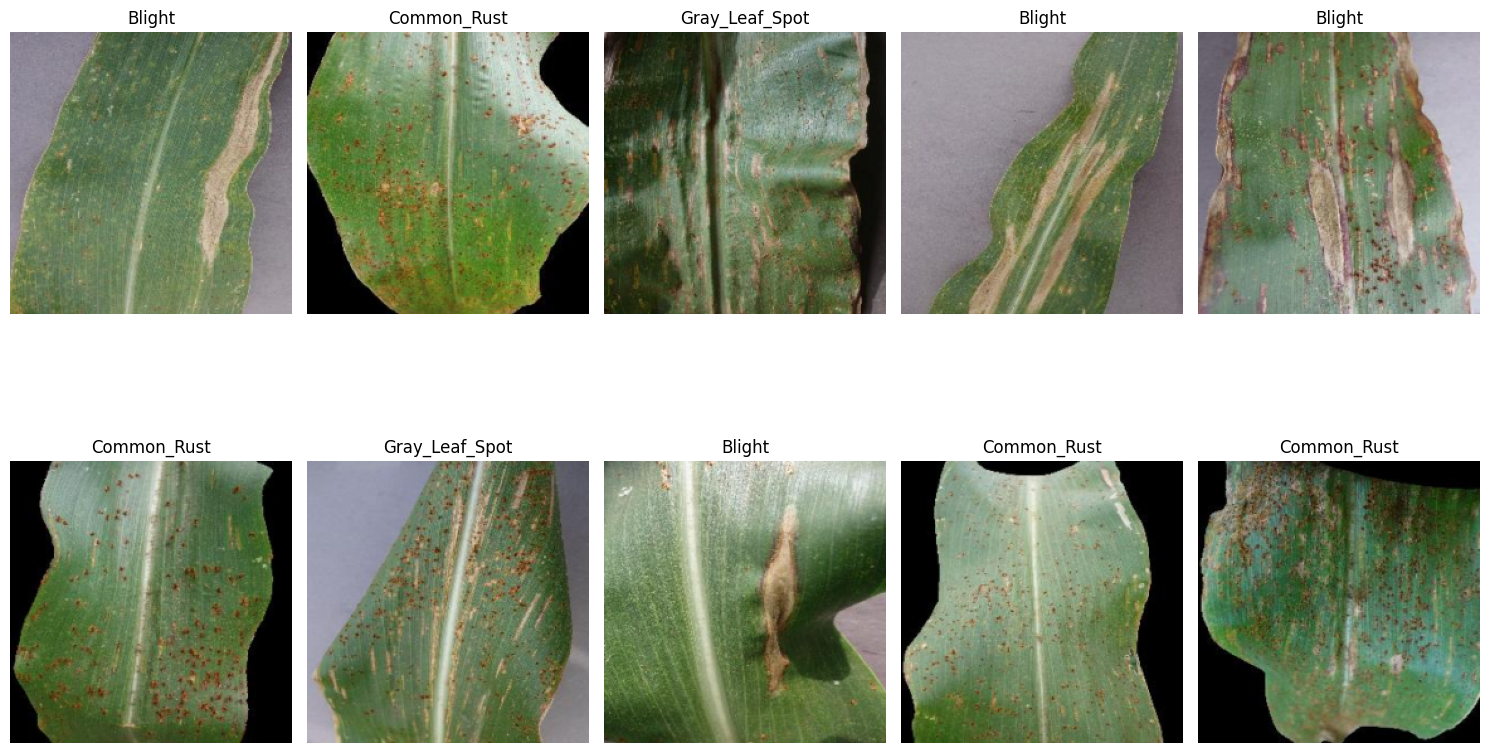

In [17]:
# Lets Visualise the random images from different folders in our  dataset
import matplotlib.pyplot as plt
import random

# Function to visualize random images from a dataset
def plot_random_images(dataset, num_images=15, rows=3, cols=5):
    # Get class labels
    labels_for_viz = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Create a figure
    fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
    ax = ax.flatten()

    # Plot random samples
    for i in range(num_images):
        sample_idx = random.randint(0, len(dataset) - 1)  # Random index
        img, label = dataset[sample_idx]  # Get image and label
        img = img.permute(1, 2, 0).numpy()  # Convert from Tensor to NumPy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = img.clip(0, 1)  # Clip to valid range
        
        ax[i].imshow(img)
        ax[i].title.set_text(labels_for_viz[label])  # Get label name
        ax[i].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Call the function with train_dataset
# plot_random_images(train_dataset, num_images=15, rows=3, cols=5)
plot_random_images(val_dataset, num_images=10, rows=2, cols=5)

In [18]:
# Let us now visualise augmented images

#  data augmentation methods are applied to Train set,
# it can be seen that images are blurred, horizontally and vertically flipped compared to the unaugmented images.


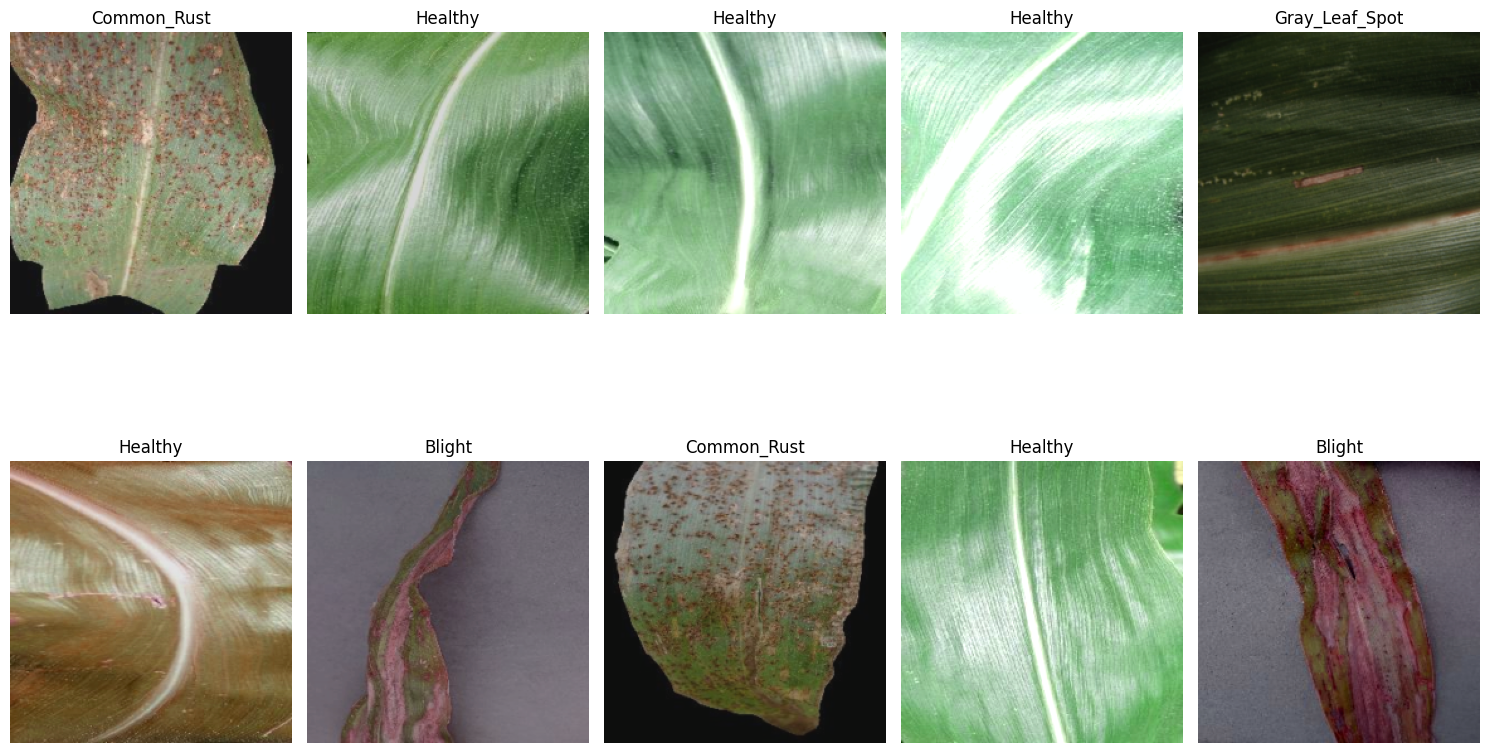

In [19]:
# Function to visualize augmented images
def plot_augmented_images(dataset, num_images=15, rows=3, cols=5):
    
    # Get class labels
    labels_for_viz = {v: k for k, v in dataset.class_to_idx.items()}
    
    # Create a figure
    fig, ax = plt.subplots(rows, cols, figsize=(15, 10))
    ax = ax.flatten()

    # Plot random augmented samples
    for i in range(num_images):
        sample_idx = random.randint(0, len(dataset) - 1)  # Random index
        img, label = dataset[sample_idx]  # Get image and label
        img = img.permute(1, 2, 0).numpy()  # Convert from Tensor to NumPy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = img.clip(0, 1)  # Clip to valid range
        
        ax[i].imshow(img)
        ax[i].title.set_text(labels_for_viz[label])  # Get label name
        ax[i].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Call the function with train_dataset
plot_augmented_images(train_dataset, num_images=10, rows=2, cols=5)


In [20]:
# Model creation and training

In [21]:
# Define the model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # Modify output layer
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


In [23]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


In [ ]:

train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

In [25]:


# Save the model
# torch.save(model.state_dict(), "saved_models/resnet50_corn_disease_PRECOPYV2.pth")

In [26]:
# Loading the saved Model


# Define the model architecture
NUM_CLASSES = 4  # Adjust this to your number of classes
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# Load the saved weights
model.load_state_dict(torch.load("saved_models/resnet50_corn_disease_PRECOPYV2.pth"))

model = model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully and is ready for evaluation.")


Model loaded successfully and is ready for evaluation.


In [27]:

# Evaluate Function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100. * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")


In [28]:
# Evaluate the model
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'\nTest Accuracy: {test_acc:.2f}%  Test Loss: {test_loss:.4f}')


Test Accuracy: 39.10%


TypeError: cannot unpack non-iterable NoneType object

In [11]:
# Visualize Predictions
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = outputs.max(1)
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Pred: {test_dataset.classes[preds[i]]} | True: {test_dataset.classes[labels[i]]}")
        plt.axis('off')
        plt.show()
